<a href="https://colab.research.google.com/github/ogigo/object_detection_with_yolo/blob/main/License_plate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle

In [3]:
api_token = {"username":"shahedshoyab","key":"1aa2d9748604f09744dac84eb27b107f"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:json.dump(api_token, file)

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download andrewmvd/car-plate-detection

 94% 190M/203M [00:01<00:00, 167MB/s]
100% 203M/203M [00:01<00:00, 138MB/s]


In [6]:
!unzip car-plate-detection.zip

Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.xml  
  inflating: annotations/Cars119.xml  
  inflating: annotations/Cars12.xm

In [7]:
import pandas as pd
pd.set_option("display.max_columns",None)
import numpy as np
import os
import glob
import xml.etree.ElementTree as et
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pyplot as mpimage
import cv2
from tqdm import tqdm
import shutil
import joblib
import torch
import yaml
from datetime import datetime
tqdm.pandas()

In [8]:
xml_path="/content/annotations"

In [9]:
path_to_xml=glob.glob(xml_path+"/"+"*.xml")
labels_dict=dict(
    file_path=[],
    label=[],
    file_name=[],
    width=[],
    height=[],
    xmin=[],
    ymin=[],
    xmax=[],
    ymax=[],

)

In [10]:
for filename in path_to_xml:
  tree=et.parse(filename)
  root=tree.getroot()
  member_object_12=root.find("size")
  member_object_2=root.find("object")
  labels_info=member_object_2.find("bndbox")


  file_name=root.find("filename").text
  label=member_object_2.find("name").text
  width=int(member_object_12.find("width").text)
  height=int(member_object_12.find("height").text)
  xmin=int(labels_info.find("xmin").text)
  ymin=int(labels_info.find("ymin").text)
  xmax=int(labels_info.find("xmax").text)
  ymax=int(labels_info.find("ymax").text)

  labels_dict["file_path"].append(filename)
  labels_dict["file_name"].append(file_name)
  labels_dict["label"].append(label)
  labels_dict["width"].append(width)
  labels_dict["height"].append(height)
  labels_dict["xmin"].append(xmin)
  labels_dict["ymin"].append(ymin)
  labels_dict["xmax"].append(xmax)
  labels_dict["ymax"].append(ymax)

In [11]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,file_path,label,file_name,width,height,xmin,ymin,xmax,ymax
0,/content/annotations/Cars58.xml,licence,Cars58.png,400,247,154,166,241,187
1,/content/annotations/Cars306.xml,licence,Cars306.png,400,400,139,282,249,310
2,/content/annotations/Cars189.xml,licence,Cars189.png,435,290,285,241,423,286
3,/content/annotations/Cars141.xml,licence,Cars141.png,400,267,266,169,307,188
4,/content/annotations/Cars217.xml,licence,Cars217.png,400,240,149,196,223,231


In [12]:
df["image_path"]="/content/images/"+df.file_name.astype(str)

In [13]:
df.head()

,file_path,label,file_name,width,height,xmin,ymin,xmax,ymax,image_path
0,/content/annotations/Cars58.xml,licence,Cars58.png,400,247,154,166,241,187,/content/images/Cars58.png
1,/content/annotations/Cars306.xml,licence,Cars306.png,400,400,139,282,249,310,/content/images/Cars306.png
2,/content/annotations/Cars189.xml,licence,Cars189.png,435,290,285,241,423,286,/content/images/Cars189.png
3,/content/annotations/Cars141.xml,licence,Cars141.png,400,267,266,169,307,188,/content/images/Cars141.png
4,/content/annotations/Cars217.xml,licence,Cars217.png,400,240,149,196,223,231,/content/images/Cars217.png


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   433 non-null    object
 1   label       433 non-null    object
 2   file_name   433 non-null    object
 3   width       433 non-null    int64 
 4   height      433 non-null    int64 
 5   xmin        433 non-null    int64 
 6   ymin        433 non-null    int64 
 7   xmax        433 non-null    int64 
 8   ymax        433 non-null    int64 
 9   image_path  433 non-null    object
dtypes: int64(6), object(4)
memory usage: 34.0+ KB


In [15]:
df['x_center'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['y_center'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bbox_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bbox_height'] = (df['ymax'] - df['ymin'])/df['height']


In [16]:
df.head()

,file_path,label,file_name,width,height,xmin,ymin,xmax,ymax,image_path,x_center,y_center,bbox_width,bbox_height
0,/content/annotations/Cars58.xml,licence,Cars58.png,400,247,154,166,241,187,/content/images/Cars58.png,0.493750,0.714575,0.217500,0.085020
1,/content/annotations/Cars306.xml,licence,Cars306.png,400,400,139,282,249,310,/content/images/Cars306.png,0.485000,0.740000,0.275000,0.070000
2,/content/annotations/Cars189.xml,licence,Cars189.png,435,290,285,241,423,286,/content/images/Cars189.png,0.813793,0.908621,0.317241,0.155172
3,/content/annotations/Cars141.xml,licence,Cars141.png,400,267,266,169,307,188,/content/images/Cars141.png,0.716250,0.668539,0.102500,0.071161
4,/content/annotations/Cars217.xml,licence,Cars217.png,400,240,149,196,223,231,/content/images/Cars217.png,0.465000,0.889583,0.185000,0.145833


In [17]:
def draw_image_with_box(index):
  image=cv2.imread("/content/images/"+df.file_name[index])
  image=cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
  fig,ax=plt.subplots(figsize=(10,10))
  rect=patches.Rectangle((df.xmin[index], df.ymin[index]), df.xmax[index] - df.xmin[index],df.ymax[index] - df.ymin[index],linewidth=1,edgecolor="r",facecolor="None")
  ax.add_patch(rect)
  ax.imshow(image)
  ax.axis("off")
  plt.show()

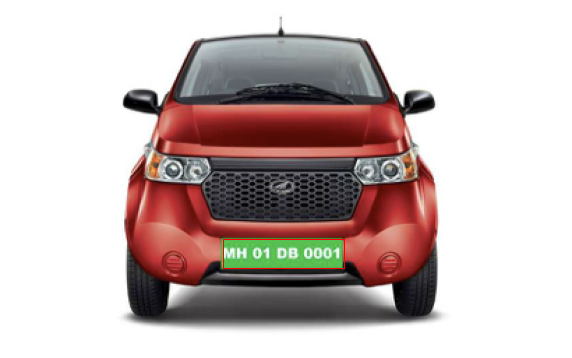

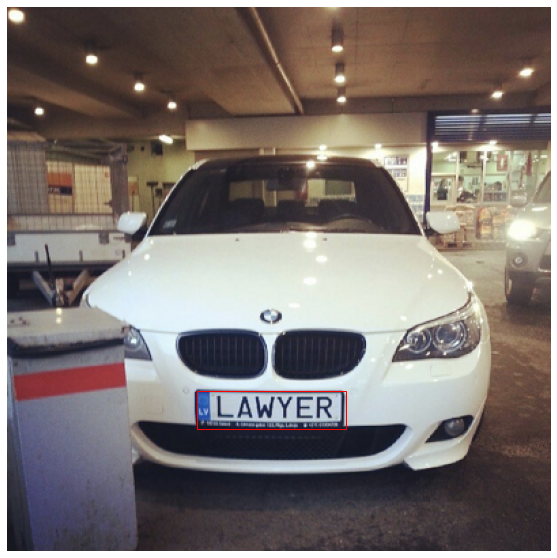

In [18]:
for i in range(2):
  draw_image_with_box(i)

In [19]:
%cd /content/
!git clone https://github.com/ultralytics/yolov5 
%cd yolov5
%pip install -qr requirements.txt  

from yolov5 import utils
display = utils.notebook_init()  

YOLOv5 🚀 v7.0-46-g96a71b1 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.4/78.2 GB disk)


In [20]:
from sklearn.model_selection import GroupKFold
kf=GroupKFold(n_splits=3)
df["fold"]=-1
for fold,(train_idx,val_idx) in enumerate(kf.split(df,groups=df.file_name.tolist())):
  df.loc[val_idx,"fold"]=fold

In [21]:
df.head()

,file_path,label,file_name,width,height,...,x_center,y_center,bbox_width,bbox_height,fold
0,/content/annotations/Cars58.xml,licence,Cars58.png,400,247,...,0.493750,0.714575,0.217500,0.085020,1
1,/content/annotations/Cars306.xml,licence,Cars306.png,400,400,...,0.485000,0.740000,0.275000,0.070000,2
2,/content/annotations/Cars189.xml,licence,Cars189.png,435,290,...,0.813793,0.908621,0.317241,0.155172,0
3,/content/annotations/Cars141.xml,licence,Cars141.png,400,267,...,0.716250,0.668539,0.102500,0.071161,2
4,/content/annotations/Cars217.xml,licence,Cars217.png,400,240,...,0.465000,0.889583,0.185000,0.145833,2


In [22]:
df.fold.value_counts()

0    145
1    144
2    144
Name: fold, dtype: int64

In [23]:
FOLD=1
train_files = []
val_files   = []
train_df = df.query("fold!=@FOLD")
valid_df = df.query("fold==@FOLD")
train_files += list(train_df.file_name.unique())
val_files += list(valid_df.file_name.unique())
len(train_files), len(val_files)

(289, 144)

In [24]:
os.makedirs('/content/tmp/yolov5/images/train', exist_ok=True)
os.makedirs('/content/tmp/yolov5/images/valid', exist_ok=True)

os.makedirs('/content/tmp/yolov5/labels/train', exist_ok=True)
os.makedirs('/content/tmp/yolov5/labels/valid', exist_ok=True)

! ls /content/tmp/yolov5/images

train  valid


In [25]:
for files in train_files:
  img_path=os.path.join("/content/images",files)
  shutil.copy(img_path,"/content/tmp/yolov5/images/train")

In [26]:
for files in val_files:
  img_path=os.path.join("/content/images",files)
  shutil.copy(img_path,"/content/tmp/yolov5/images/valid")

In [27]:
for _,row in tqdm(train_df.iterrows(),total=len(train_df)):
  image_file=row["file_name"].split(".")[0]
  label_text=f"0 {row['x_center']} {row['y_center']} {row['bbox_width']} {row['bbox_height']}" 
  with open(os.path.join("/content/tmp/yolov5/labels/train",f"{image_file}.txt"),"w") as f:
    f.write(label_text)


100%|██████████| 289/289 [00:00<00:00, 3833.87it/s]


In [28]:
for _,row in tqdm(valid_df.iterrows(),total=len(valid_df)):
  image_file=row["file_name"].split(".")[0]
  label_text=f"0 {row['x_center']} {row['y_center']} {row['bbox_width']} {row['bbox_height']}" 
  with open(os.path.join("/content/tmp/yolov5/labels/valid",f"{image_file}.txt"),"w") as f:
    f.write(label_text)

100%|██████████| 144/144 [00:00<00:00, 3097.60it/s]


In [29]:
yaml_text = """train: /content/tmp/yolov5/images/train
val: /content/tmp/yolov5/images/valid

nc: 1
names: ['license plate']"""

with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml


train: /content/tmp/yolov5/images/train
val: /content/tmp/yolov5/images/valid

nc: 1
names: ['license plate']

In [30]:
!python train.py --img 640 --batch 32 --epochs 50 --data data/data.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache
end = datetime.now()

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-46-g96a71b1 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv

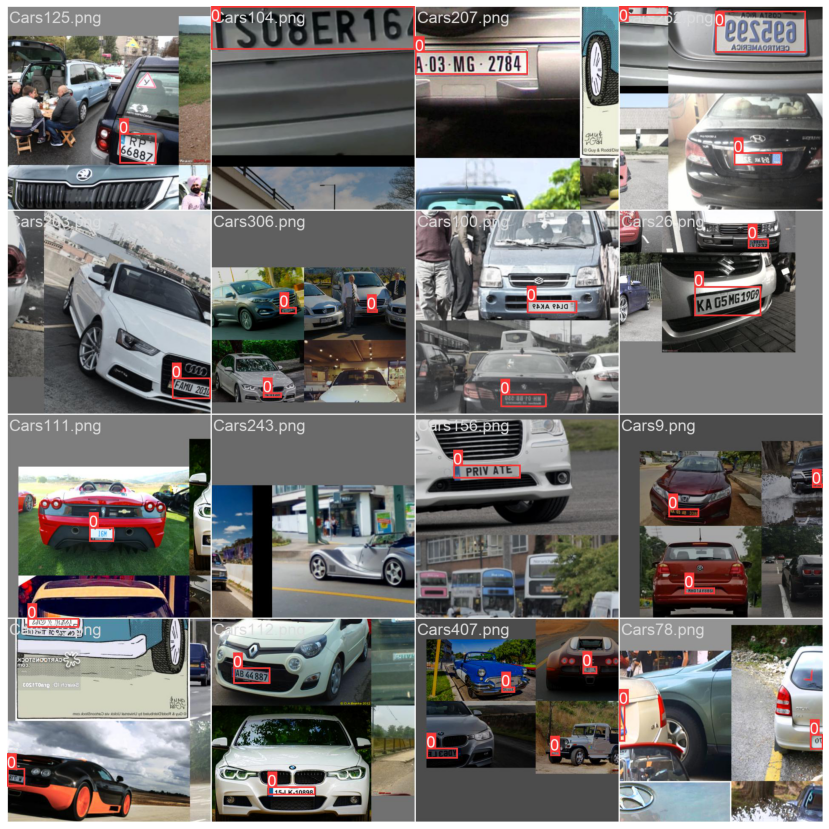

In [31]:
img = plt.imread('/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()